# scVelo #2

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", UserWarning)

import anndata
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from natsort import natsorted
from matplotlib import rcParams

# n_blocks = 8
random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80, dpi_save=600, vector_friendly=False)
sc.settings.verbosity = 3

scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.settings.set_figure_params('scvelo', dpi_save=600)

In [2]:
%run ../scripts/helpers.py

In [3]:
adata = sc.read("../data/processed/01_raw_counts.h5ad")

metadata = pd.read_csv("../data/processed/02_metadata.csv", index_col=0)
adata = adata[metadata.index]
adata.obs = metadata

adata.obsm['X_umap'] = pd.read_csv("../data/processed/02_umap.csv", index_col=0).to_numpy()
adata.obsm['X_mnn'] = pd.read_csv("../data/processed/02_mnn.csv", index_col=0).to_numpy()

# fix spaces in metadata
adata.obs.Cell_barcode = adata.obs.Cell_barcode.str.strip().astype('category')
adata.obs.Pool_barcode = adata.obs.Pool_barcode.str.strip()
adata.obs['barcodes'] = adata.obs['Pool_barcode'].str.strip() + adata.obs['Cell_barcode'].str.strip()

adata.obs.cluster_names = adata.obs.cluster_names.astype('category')

In [4]:
adata

AnnData object with n_obs × n_vars = 6279 × 34016
    obs: 'orig.ident', 'nUMI', 'nGene', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Day', 'Amp_batch_ID.1', 'Well_ID.1', 'Protocol', 'FACS_index', 'percent.mito', 'percent.ercc', 'nCount_RNA', 'nFeature_RNA', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1.4', 'seurat_clusters', 'cluster_names', 'barcodes'
    obsm: 'X_umap', 'X_mnn'

In [5]:
velocity_batches = []
for batch in adata.obs.Batch.unique():
    print(f"Processing {batch}")
    velocity_batch = buildAnndataFromStar(f"../data/raw/velocity/{batch}/Solo.out/")
    obs = adata[adata.obs.Batch == batch].obs.reset_index().set_index('barcodes')
    common_cells = np.intersect1d(obs.index, velocity_batch.obs_names)
    
    velocity_batch = velocity_batch[common_cells].copy()
    velocity_batch.obs = obs.loc[common_cells]
    velocity_batch.obs = velocity_batch.obs.set_index("Well_ID")

    velocity_batches.append(velocity_batch)

Processing SB1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB7


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB8


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing SB9


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
merged = anndata.concat(velocity_batches)

In [7]:
adata_velocity = scv.utils.merge(adata, merged)

In [8]:
adata_velocity

AnnData object with n_obs × n_vars = 6279 × 33924
    obs: 'orig.ident', 'nUMI', 'nGene', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Day', 'Amp_batch_ID.1', 'Well_ID.1', 'Protocol', 'FACS_index', 'percent.mito', 'percent.ercc', 'nCount_RNA', 'nFeature_RNA', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1.4', 'seurat_clusters', 'cluster_names', 'barcodes', 'index', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    obsm: 'X_umap', 'X_mnn'
    layers: 'spliced', 'unspliced', 'ambiguous'

In [9]:
adata_velocity.write("../data/processed/05_scvelo_ver_2.h5ad")

... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical
... storing 'barcodes' as categorical


## Full dataset

In [10]:
adata_velocity = sc.read("../data/processed/05_scvelo_ver_2.h5ad")

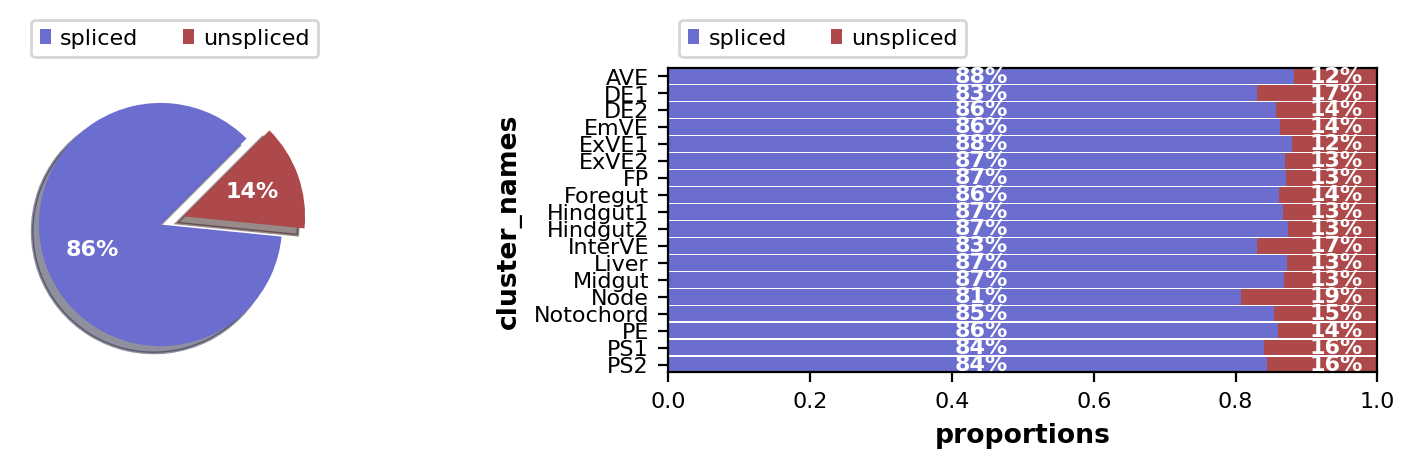

In [11]:
scv.pl.proportions(adata_velocity, groupby='cluster_names')

In [12]:
adata_velocity = run_scvelo(adata_velocity)

Filtered out 26427 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.


computing PCA
    on highly variable genes
    with n_comps=50


Extracted 2000 highly variable genes.


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/12 cores)


  0%|          | 0/910 [00:00<?, ?gene/s]

    finished (0:02:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


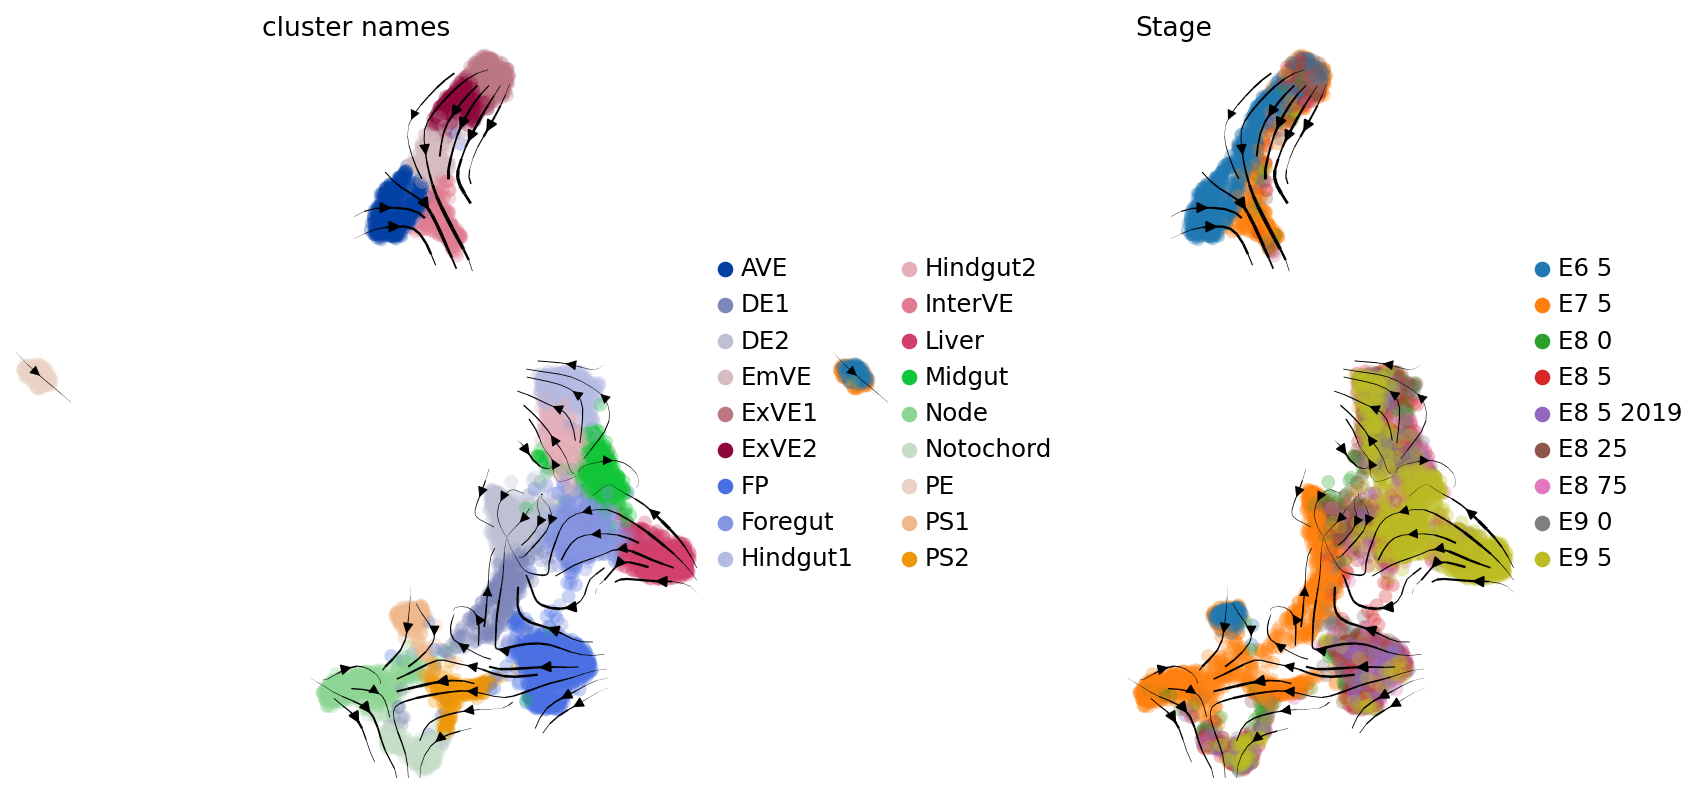

In [13]:
rcParams['figure.figsize'] = [8, 8]
scv.pl.velocity_embedding_stream(adata_velocity, basis='umap', color=['cluster_names', 'Stage'], legend_loc = 'right')

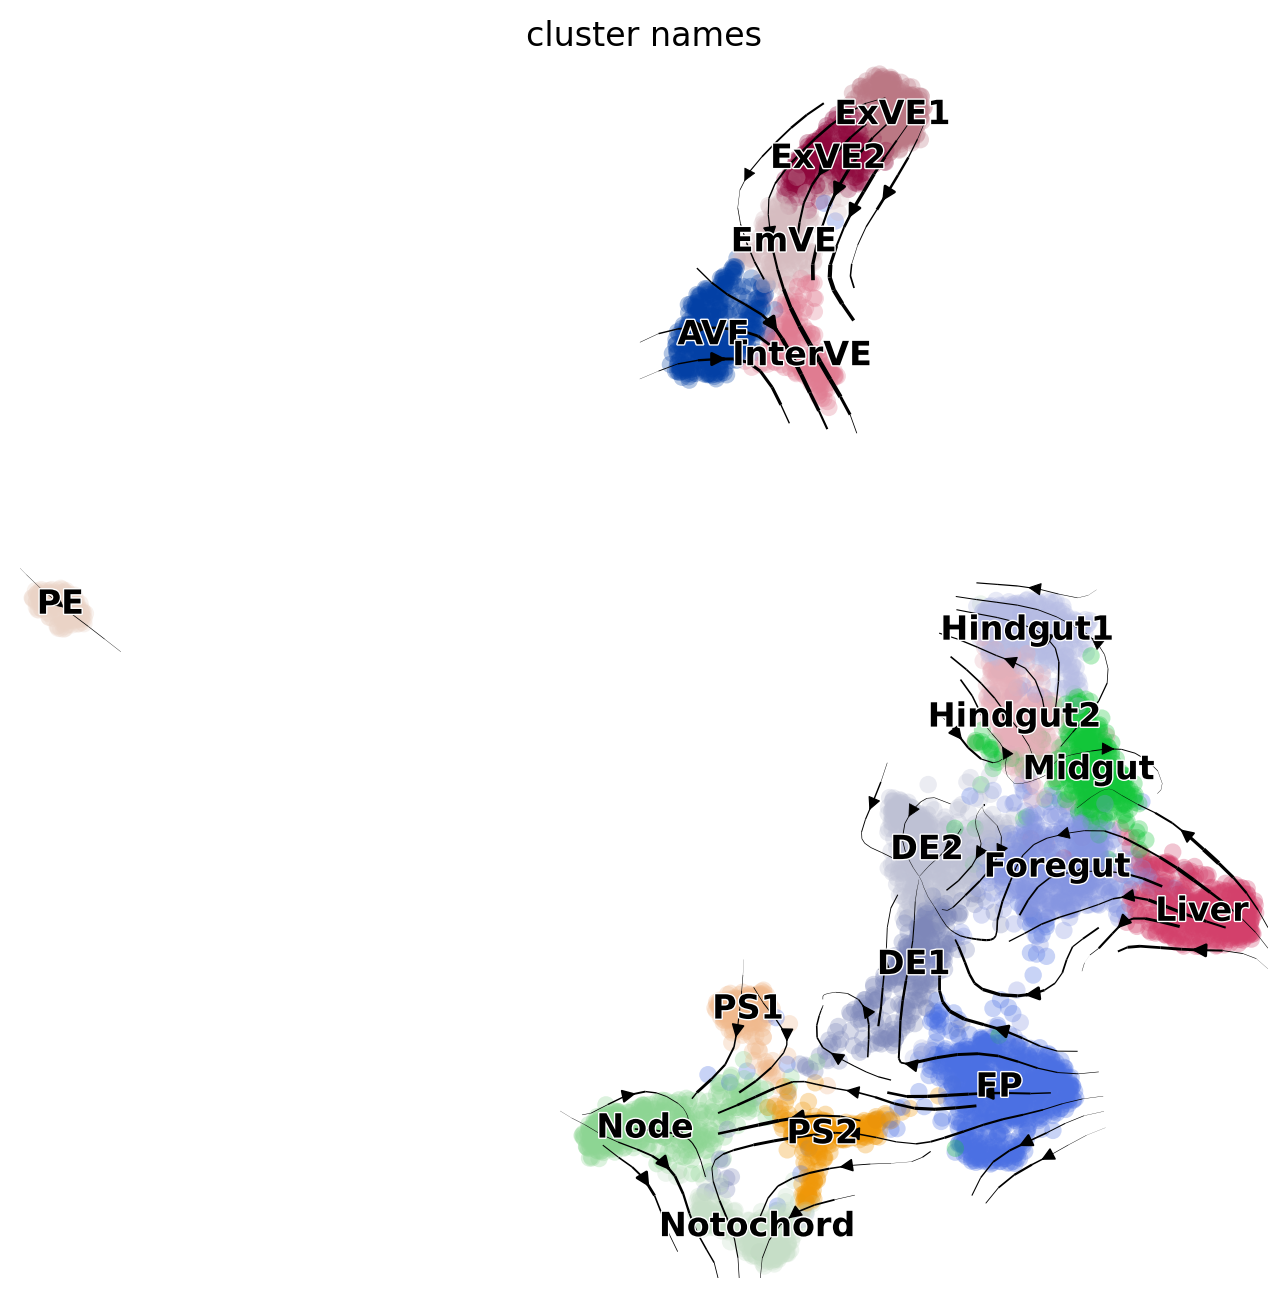

In [14]:
rcParams['figure.figsize'] = [8, 8]
scv.pl.velocity_embedding_stream(adata_velocity, basis='umap', color='cluster_names')

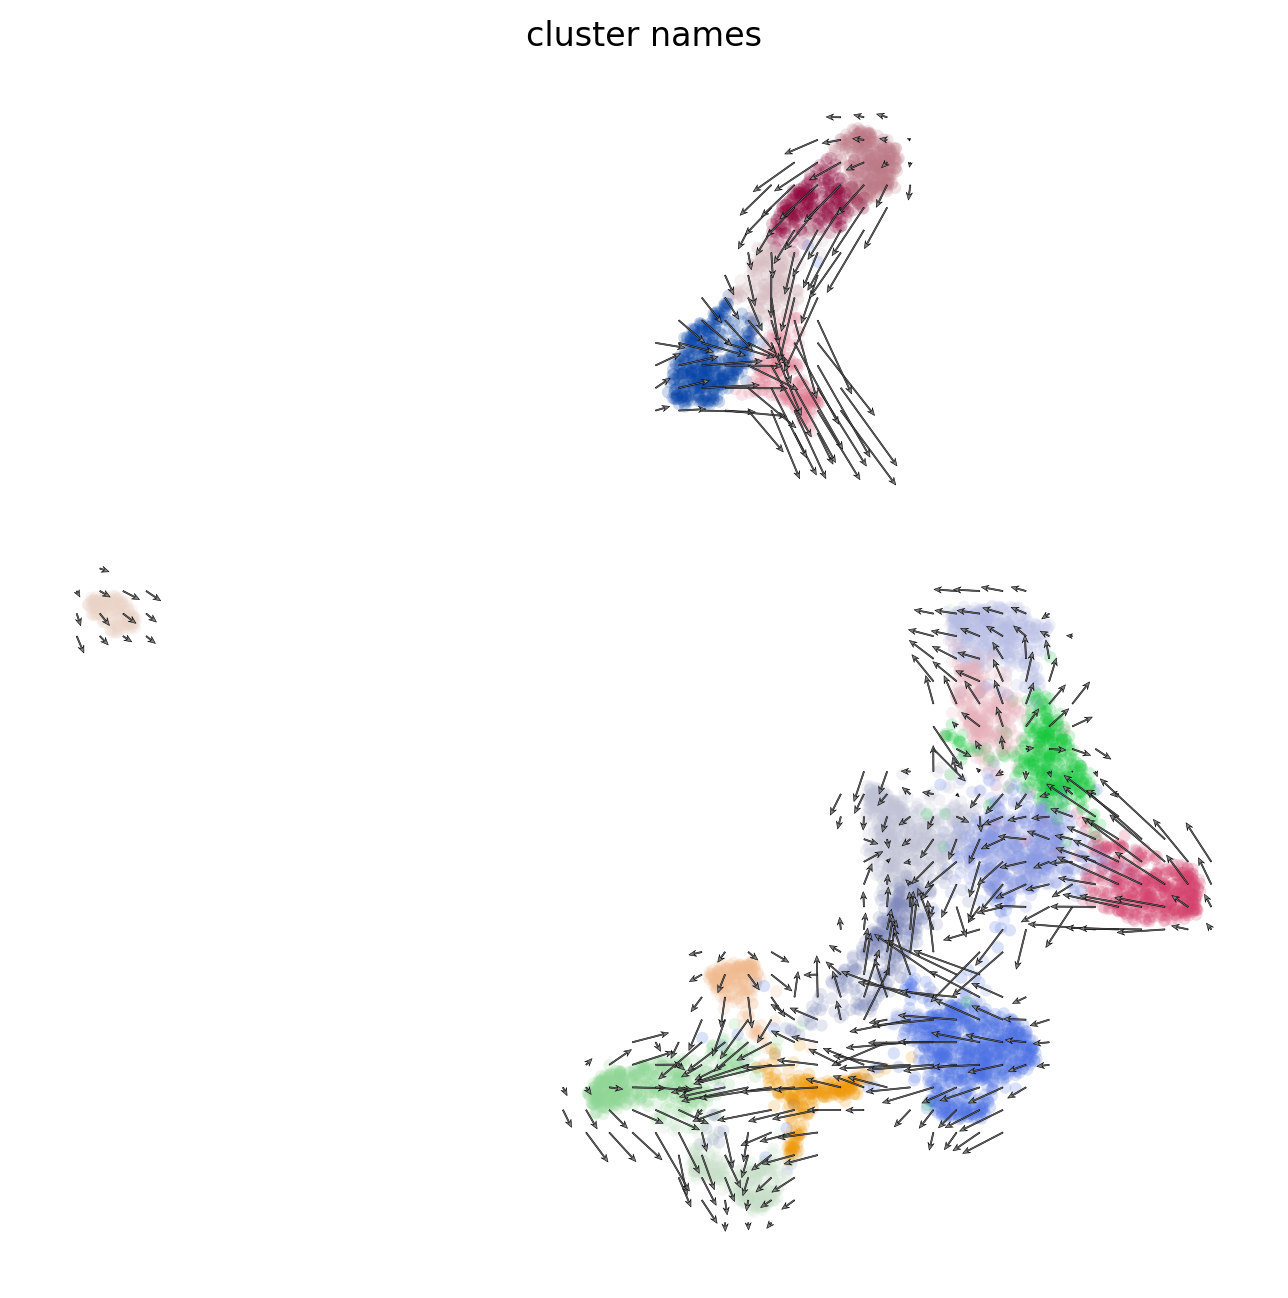

In [15]:
scv.pl.velocity_embedding_grid(adata_velocity, basis='umap', color='cluster_names', arrow_length=5)

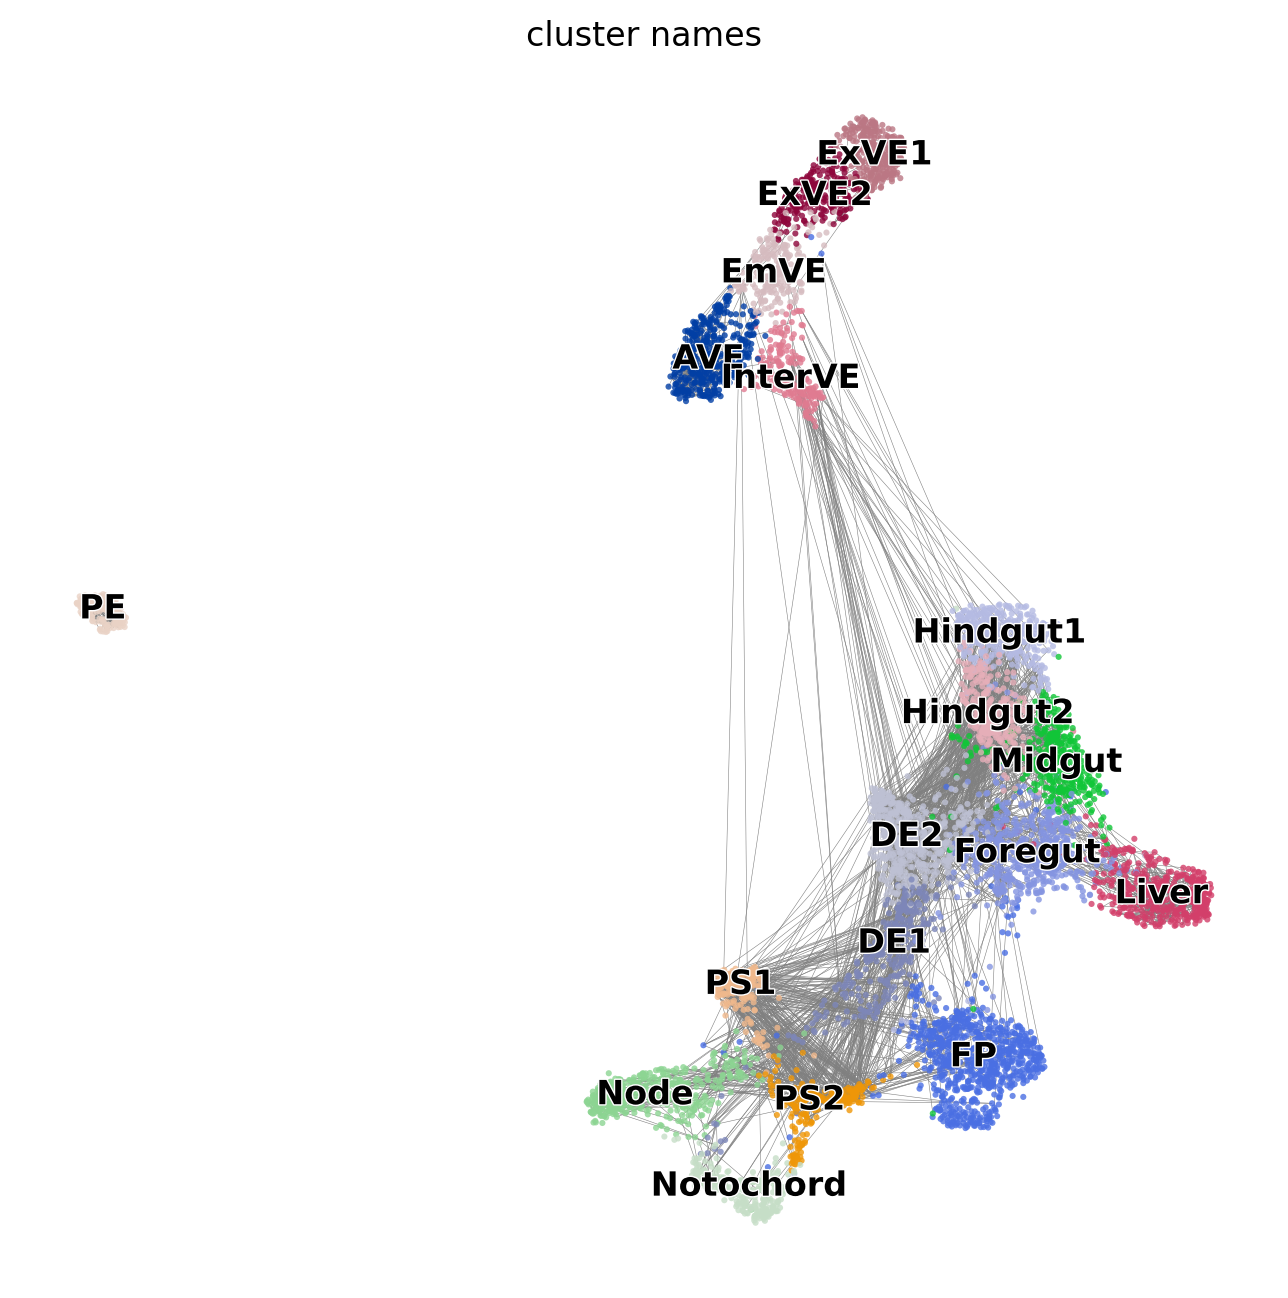

In [16]:
scv.pl.velocity_graph(adata_velocity, threshold=.8, color='cluster_names')

In [ ]:
!jupyter nbconvert --to html 05_scvelo_ver_2.ipynb --output-dir="../reports"